In [1]:
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split
# 폴더 안으로 이동
%cd Scene-Classification-Dataset-Split

Cloning into 'Scene-Classification-Dataset-Split'...
remote: Enumerating objects: 17038, done.
remote: Total 17038 (delta 0), reused 0 (delta 0), pack-reused 17038
Receiving objects: 100% (17038/17038), 136.02 MiB | 20.82 MiB/s, done.
Updating files: 100% (17035/17035), done.
/content/Scene-Classification-Dataset-Split


In [2]:
import os


classes = ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']
train_path = 'train/'
val_path = 'val/'

print("[ 학습 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(train_path + classes[i]))}')

print("[ 검증 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(val_path + classes[i]))}')

[ 학습 데이터셋 ]
클래스 0의 개수: 2105
클래스 1의 개수: 2205
클래스 2의 개수: 2363
클래스 3의 개수: 2438
클래스 4의 개수: 2224
클래스 5의 개수: 2292
[ 검증 데이터셋 ]
클래스 0의 개수: 523
클래스 1의 개수: 540
클래스 2의 개수: 594
클래스 3의 개수: 599
클래스 4의 개수: 560
클래스 5의 개수: 591


In [3]:
import torch
from torchvision import datasets, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train)
val_dataset = datasets.ImageFolder(val_path, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


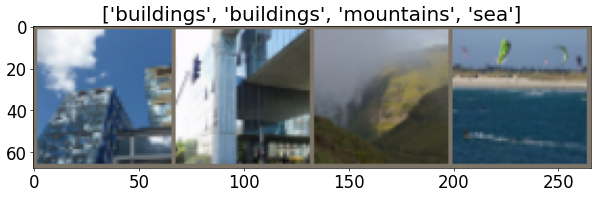

In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 이미지 정규화(normalization) 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 학습 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(train_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 20, kernel size: 5 X 5, stride: 1, zero padding: 0
3 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | # of kernel: 50, kernel size: 5 X 5, stride: 1, zero padding: 0
5 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
6 | Fully Connected | # of neuron: 500
7 | Activation | ReLU
8 | Fully Connected | # of neuron: 6
9 | Softmax | 6 classes



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (20 x 60 x 60)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (20 x 30 x 30)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (50 x 26 x 26)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (50 x 13 x 13)
        self.fc1 = nn.Linear(50 * 13 * 13, 500)
        # → 차원(dimension): (500)
        self.fc2 = nn.Linear(500, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

In [ ]:
import time
import torch.optim as optim


net = LeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train accuarcy: 49.57070521758274
Train average loss: 0.04025698881676973
[ Validation epoch: 1 ]
Accuarcy: 64.89580275902554
Average loss: 0.030300107613175295
Model saved! (time elapsed: 12.862390995025635)
[ Train epoch: 1 ]
Train accuarcy: 57.80435899317531
Train average loss: 0.034424052839803355
[ Validation epoch: 2 ]
Accuarcy: 69.62136777223364
Average loss: 0.026256141002695337
Model saved! (time elapsed: 25.451782941818237)
[ Train epoch: 2 ]
Train accuarcy: 60.798414911572614
Train average loss: 0.03176219963997662
[ Validation epoch: 3 ]
Accuarcy: 69.88552979160552
Average loss: 0.025915249722914365
Model saved! (time elapsed: 37.952213764190674)
[ Train epoch: 3 ]
Train accuarcy: 62.33213473251633
Train average loss: 0.031134526115647588
[ Validation epoch: 4 ]
Accuarcy: 71.70531259172293
Average loss: 0.024611414659747567
Model saved! (time elapsed: 50.684082984924316)
[ Train epoch: 4 ]
Train accuarcy: 64.32817201144786
Train average loss: 0.029697364924317404
[ Validati

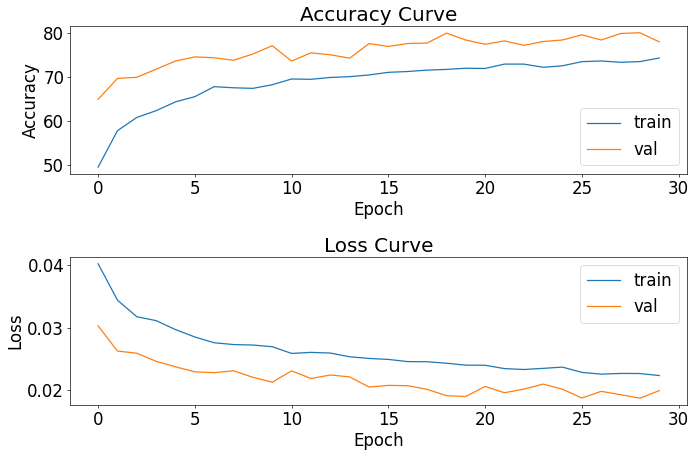

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

#### <b>(알아보기) 혼동 행렬 시각화하기</b>

* 참고: [Seaborn.heatmap 공식 문서](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
* 각 클래스에 대하여 정확히 분류하는지 확인하기 위해 <b>혼동 행렬(confusion matrix)</b>을 생성할 수 있습니다.

In [ ]:
# 네트워크에 데이터셋을 입력하여 혼동 행렬(confusion matrix)을 계산하는 함수
def get_confusion_matrix(net, num_classes, data_loader):
    net.eval() # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


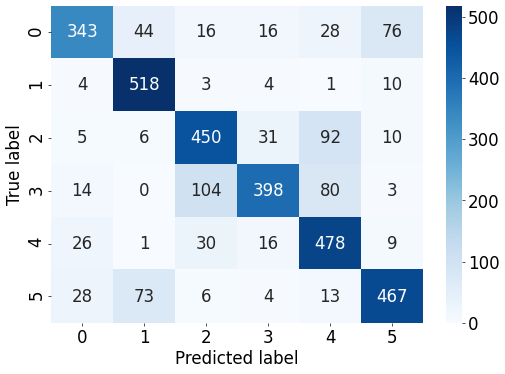

[ 각 클래스에 따른 정확도 ]
tensor([0.6558, 0.9593, 0.7576, 0.6644, 0.8536, 0.7902])
[ 전체 평균 정확도 ]
tensor(0.7790)


In [ ]:
import pandas as pd
import seaborn as sns


net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 128, kernel size: 8 X 8, stride: 1, zero padding: 0
3 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | # of kernel: 256, kernel size: 8 X 8, stride: 1, zero padding: 0
5 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
6 | Convolution | # of kernel: 512, kernel size: 4 X 4, stride: 1, zero padding: 0
7 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
8 | Fully Connected | # of neuron: 4096
9 | Activation | ReLU
10 | Fully Connected | # of neuron: 6
11 | Softmax | 6 classes


In [7]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        # (3*64*64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=8, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # (128*28*28)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # (256*10*10)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # (512*3*3)
        self.fc1 = nn.Linear(512*3*3, 4096)

        self.fc2 = nn.Linear(4096, 6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
import time
import torch.optim as optim


net = CustomLeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "CustomLeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 48.646070301607104
Train average loss: 0.04069615167104254
[ Validation epoch: 1 ]
Accuarcy: 61.13883181684767
Average loss: 0.03174856421462525
Model saved! (time elapsed: 32.04092049598694)
[ Train epoch: 1 ]
Train accuarcy: 55.94775078887503
Train average loss: 0.03543205945588194
[ Validation epoch: 2 ]
Accuarcy: 65.336072791312
Average loss: 0.029827756251202743
Model saved! (time elapsed: 58.0926079750061)
[ Train epoch: 2 ]
Train accuarcy: 58.98583694136641
Train average loss: 0.033326378670495996
[ Validation epoch: 3 ]
Accuarcy: 65.51218080422659
Average loss: 0.028508879377725085
Model saved! (time elapsed: 82.74038004875183)
[ Train epoch: 3 ]
Train accuarcy: 60.490203272914066
Train average loss: 0.03237941772578931
[ Validation epoch: 4 ]
Accuarcy: 67.62547695920165
Average loss: 0.027666111023222417
Model saved! (time elapsed: 108.07102489471436)
[ Train epoch: 4 ]
Train accuarcy: 61.86981727452851
Train average loss: 0.03155512996786119

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 96, kernel size: 5 X 5, stride: 1, zero padding: 2
3 | Activation | ReLU
4 | Normalization | LRN (Local Response Normalization), size: 5
5 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
6 | Convolution | # of kernel: 256, kernel size: 5 X 5, stride: 1, zero padding: 2
7 | Activation | ReLU
8 | Normalization | LRN (Local Response Normalization), size: 5
9 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
10 | Convolution | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
11 | Activation | ReLU
12 | Convolution | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
13 | Activation | ReLU
14 | Convolution | # of kernel: 256, kernel size: 3 X 3, stride: 1, zero padding: 1
15 | Activation | ReLU
16 | Pooling | max pooling, kernel size: 3 X 3, stride: 2
17 | Fully Connected | # of neuron: 4096
18 | Activation | ReLU
19 | Dropout | Probability: 0.5
20 | Fully Connected | # of neuron: 6
21 | Dropout | Probability: 0.5
22 | Softmax | 6 classes

* 표와 동일하게 정상적으로 구현했다면, <b>83~85%가량의 정확도</b>를 얻을 수 있습니다.

In [26]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        ## conv1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=2)
        # (96, 64, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # (96, 31, 31)

        ## conv2
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        # (256, 31, 31)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # (256, 15, 15)

        ## conv3
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        # (384, 15, 15)

        ## conv4
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # (384, 15, 15)

        ## conv5
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        # (256, 15, 15)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # (256, 7, 7)

        ## fc1
        self.fc1 = nn.Linear(256*7*7, 4096)
        self.dropout1 = nn.Dropout(0.5)
        # (4096, )

        ## fc2
        self.fc2 = nn.Linear(4096, 6)
        self.dropout2 = nn.Dropout(0.5)

        ## localResponseNorm
        self.local = nn.LocalResponseNorm(size=5, k=2)

    def forward(self, x):
        # layer1
        x = F.relu(self.conv1(x))
        x = self.local(x)
        x = self.pool1(x)

        # layer2
        x = F.relu(self.conv2(x))
        x = self.local(x)
        x = self.pool2(x)

        # layer3
        x = F.relu(self.conv3(x))

        # layer4
        x = F.relu(self.conv4(x))

        # layer5
        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        # fcn 1
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        # fc1 2
        x = self.fc2(x)
        x = self.dropout2(x)

        return x

In [27]:
import time
import torch.optim as optim


net = AlexNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 24.642254347985617
Train average loss: 0.053819992383577736
[ Validation epoch: 1 ]
Accuarcy: 52.97916055180511
Average loss: 0.04248520961982048
Model saved! (time elapsed: 33.05168080329895)
[ Train epoch: 1 ]
Train accuarcy: 36.34695824466134
Train average loss: 0.04702962127200416
[ Validation epoch: 2 ]
Accuarcy: 53.59553859700616
Average loss: 0.03847626541799417
Model saved! (time elapsed: 66.99094152450562)
[ Train epoch: 2 ]
Train accuarcy: 39.86937697218757
Train average loss: 0.045040073928054786
[ Validation epoch: 3 ]
Accuarcy: 58.73202230701497
Average loss: 0.03728557226067944
Model saved! (time elapsed: 101.28843069076538)
[ Train epoch: 3 ]
Train accuarcy: 40.801350260512216
Train average loss: 0.04408604787119838
[ Validation epoch: 4 ]
Accuarcy: 64.25007337833871
Average loss: 0.03289501534762325
Model saved! (time elapsed: 135.30892038345337)
[ Train epoch: 4 ]
Train accuarcy: 42.812064284141776
Train average loss: 0.04312620278787

In [30]:
# ResNet을 위한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (stride 값이 2라면, 너비와 높이가 절반으로 감소)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (stride 값이 1이므로, 너비와 높이가 유지)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# LightResNet 클래스 정의
class LightResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(LightResNet, self).__init__()
        self.in_planes = 16

        # 16개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def LightResNet20():
    return LightResNet(BasicBlock, [3, 3, 3])


def LightResNet32():
    return LightResNet(BasicBlock, [5, 5, 5])


def LightResNet44():
    return LightResNet(BasicBlock, [7, 7, 7])


def LightResNet56():
    return LightResNet(BasicBlock, [9, 9, 9])


def LightResNet110():
    return LightResNet(BasicBlock, [18, 18, 18])

In [31]:
import time
import torch.optim as optim


net = LightResNet20()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet20.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 51.985029720408015
Train average loss: 0.03660367609793734
[ Validation epoch: 1 ]
Accuarcy: 63.80980334605225
Average loss: 0.029625212058035692
Model saved! (time elapsed: 24.66127347946167)
[ Train epoch: 1 ]
Train accuarcy: 64.54832318191825
Train average loss: 0.028844068998145175
[ Validation epoch: 2 ]
Accuarcy: 71.76401526269446
Average loss: 0.0242157080742422
Model saved! (time elapsed: 46.427006244659424)
[ Train epoch: 2 ]
Train accuarcy: 69.1494826447494
Train average loss: 0.02574750730758141
[ Validation epoch: 3 ]
Accuarcy: 75.99060757264455
Average loss: 0.021473042166124594
Model saved! (time elapsed: 66.89499402046204)
[ Train epoch: 3 ]
Train accuarcy: 71.51243854113157
Train average loss: 0.024018447775916694
[ Validation epoch: 4 ]
Accuarcy: 77.92779571470501
Average loss: 0.019549853988221427
Model saved! (time elapsed: 87.4196548461914)
[ Train epoch: 4 ]
Train accuarcy: 73.17091069200852
Train average loss: 0.02272401940029156

In [36]:
# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
import time
import torch.optim as optim


net = ResNet18()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "ResNet18.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 54.634182138401705
Train average loss: 0.03552350132220593
[ Validation epoch: 1 ]
Accuarcy: 64.04461402993836
Average loss: 0.030625102927267008
Model saved! (time elapsed: 56.392067432403564)
[ Train epoch: 1 ]
Train accuarcy: 66.28017905628532
Train average loss: 0.027683555574666258
[ Validation epoch: 2 ]
Accuarcy: 76.22541825653067
Average loss: 0.020909708783813402
Model saved! (time elapsed: 112.09643793106079)
[ Train epoch: 2 ]
Train accuarcy: 70.65384897629706
Train average loss: 0.024552799536580516
[ Validation epoch: 3 ]
Accuarcy: 75.72644555327267
Average loss: 0.020803920747529105
Model saved! (time elapsed: 168.0892436504364)
[ Train epoch: 3 ]
Train accuarcy: 73.06083510677331
Train average loss: 0.022823793206008802
[ Validation epoch: 4 ]
Accuarcy: 75.2861755209862
Average loss: 0.020782165577028867
Model saved! (time elapsed: 224.10530710220337)
[ Train epoch: 4 ]
Train accuarcy: 75.04953401335584
Train average loss: 0.02116022261

In [34]:
mixup_alpha = 1.0


def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_with_mixup(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets) # Mixup 진행
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)

In [38]:
transforms_train_transferred = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val_transferred = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_transferred = datasets.ImageFolder(train_path, transforms_train_transferred)
val_dataset_transferred = datasets.ImageFolder(val_path, transforms_val_transferred)

train_dataloader_transferred = torch.utils.data.DataLoader(train_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)
val_dataloader_transferred = torch.utils.data.DataLoader(val_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset_transferred))
print('Validation dataset size:', len(val_dataset_transferred))

class_names = train_dataset_transferred.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


In [ ]:
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 20
learning_rate = 0.001 # 일반적으로 fine-tuning을 진행할 때는 학습률(learning rate)을 낮게 설정
file_name = "ResNet18Transferred.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 76.73735965362883
Train average loss: 0.03927191147811609
[ Validation epoch: 1 ]
Accuarcy: 88.99324919283828
Average loss: 0.01971462501815977
Model saved! (time elapsed: 57.68897724151611)
[ Train epoch: 1 ]
Train accuarcy: 82.65208776693329
Train average loss: 0.02987067018737882
[ Validation epoch: 2 ]
Accuarcy: 90.72497798649839
Average loss: 0.016098890513715276
Model saved! (time elapsed: 114.97562456130981)
[ Train epoch: 2 ]
Train accuarcy: 84.58207969472372
Train average loss: 0.026206359815353027
[ Validation epoch: 3 ]
Accuarcy: 91.34135603169945
Average loss: 0.01570589934555813
Model saved! (time elapsed: 172.80669021606445)
[ Train epoch: 3 ]
Train accuarcy: 85.52139135539737
Train average loss: 0.024795979192507644
[ Validation epoch: 4 ]
Accuarcy: 88.02465512180804
Average loss: 0.022295160712753535
Model saved! (time elapsed: 230.6609981060028)
[ Train epoch: 4 ]
Train accuarcy: 86.18184486680855
Train average loss: 0.023779920512215

In [39]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 20:
        lr /= 8
    if epoch >= 40:
        lr /= 8
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [46]:
net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 25
learning_rate = 0.001 # 일반적으로 fine-tuning을 진행할 때는 학습률(learning rate)을 낮게 설정
file_name = "ResNet50Transferred.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train_with_mixup(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ Train epoch: 0 ]
Train accuarcy: 58.94568051938616
Train average loss: 0.07274579404997285
[ Validation epoch: 1 ]
Accuarcy: 89.28676254769591
Average loss: 0.02622228878787231
Model saved! (time elapsed: 158.26367855072021)
[ Train epoch: 1 ]
Train accuarcy: 63.5686010442061
Train average loss: 0.06591856317040926
[ Validation epoch: 2 ]
Accuarcy: 89.60962723803934
Average loss: 0.024793061634155532
Model saved! (time elapsed: 316.4031009674072)
[ Train epoch: 2 ]
Train accuarcy: 66.42563674365663
Train average loss: 0.06202282838962429
[ Validation epoch: 3 ]
Accuarcy: 91.84032873495744
Average loss: 0.020722033795475575
Model saved! (time elapsed: 473.56388115882874)
[ Train epoch: 3 ]
Train accuarcy: 67.04042215267486
Train average loss: 0.06010190647311682
[ Validation epoch: 4 ]
Accuarcy: 91.5468153800998
Average loss: 0.01967733963724802
Model saved! (time elapsed: 630.5126142501831)
[ Train epoch: 4 ]
Train accuarcy: 66.66330523703334
Train average loss: 0.06066973006470744
[